In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/random-images-for-face-emotion-recognition/surprise/images (68)_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T202610.051_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T203343.130_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T202951.236_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T202431.675_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T202508.777_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T004452.516_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T202620.534_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T203753.431_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise

In [6]:
import os

# List what's available under /kaggle/input
for d in os.listdir("/kaggle/input"):
    print(d)

random-images-for-face-emotion-recognition


In [7]:

DATASET_DIR = "/kaggle/input/random-images-for-face-emotion-recognition"


print("Subfolders:", os.listdir(DATASET_DIR))

Subfolders: ['surprise', 'fear', 'sadness', 'neutrality', 'disgust', 'contempt', 'happiness', 'anger']


In [8]:
import tensorflow as tf
from tensorflow.keras import layers

base_dir = DATASET_DIR
img_size = (224, 224)
batch_size = 32

# 70% train, 30% temp (we'll split temp into val/test)
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.30,
    subset="training",
    seed=42,
    shuffle=True,
    image_size=img_size,
    color_mode="rgb",          # switch to rgb
    batch_size=batch_size,
    label_mode="categorical"   # one-hot labels
)

temp_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.30,
    subset="validation",
    seed=42,
    shuffle=True,
    image_size=img_size,
    color_mode="rgb",
    batch_size=batch_size,
    label_mode="categorical"
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names, "| num_classes:", num_classes)

# Split temp_ds into 15% val + 15% test
val_batches = tf.data.experimental.cardinality(temp_ds)
test_size = val_batches // 2
test_ds = temp_ds.take(test_size)
val_ds  = temp_ds.skip(test_size)

# Normalization + performance
normalizer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x,y: (normalizer(x), y)).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(lambda x,y: (normalizer(x), y)).cache().prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.map(lambda x,y: (normalizer(x), y)).cache().prefetch(tf.data.AUTOTUNE)

for split_name, ds in [("Train", train_ds), ("Val", val_ds), ("Test", test_ds)]:
    print(split_name, "batches:", tf.data.experimental.cardinality(ds).numpy())

Found 5558 files belonging to 8 classes.
Using 3891 files for training.
Found 5558 files belonging to 8 classes.
Using 1667 files for validation.
Classes: ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'surprise'] | num_classes: 8
Train batches: 122
Val batches: 27
Test batches: 26


In [24]:
from tensorflow.keras import layers, models

num_classes = 8

model = models.Sequential([
    layers.Input(shape=(224,224,3)),
    #layers.Rescaling(1./255),
    layers.Conv2D(16, 4, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 16)   │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,048 (113.47 KB)

 Trainable params: 28,824 (112.59 KB)

 Non-trainable params: 224 (896.00 B)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
    ModelCheckpoint("best_baseline.keras", monitor="val_accuracy", save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.2498 - loss: 2.0053 - val_accuracy: 0.0659 - val_loss: 2.1191
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.2606 - loss: 1.9304 - val_accuracy: 0.0994 - val_loss: 2.3205
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.2590 - loss: 1.9150 - val_accuracy: 0.1856 - val_loss: 2.2525
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.2715 - loss: 1.8820 - val_accuracy: 0.0946 - val_loss: 2.3511
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.2740 - loss: 1.8864 - val_accuracy: 0.1377 - val_loss: 2.0388
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.2802 - loss: 1.8537 - val_accuracy: 0.2754 - val_loss: 1.9055
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.2904 - loss: 1.8551 - val_accuracy: 0.2311 - val_loss: 1.9183
Epoch 8/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.2829 - loss: 1.8562 - val_acc

In [27]:
print("Train:", model.evaluate(train_ds, verbose=0))
print("Val  :", model.evaluate(val_ds,   verbose=0))
print("Test :", model.evaluate(test_ds,  verbose=0))

Train: [1.8646056652069092, 0.2929838001728058]
Val  : [1.8603360652923584, 0.2958083748817444]
Test : [1.944676160812378, 0.2548076808452606]


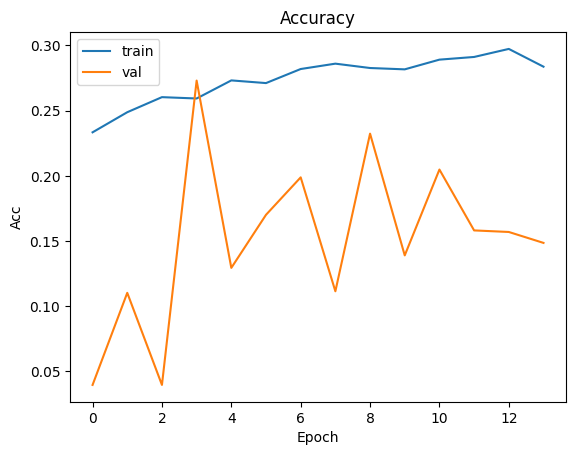

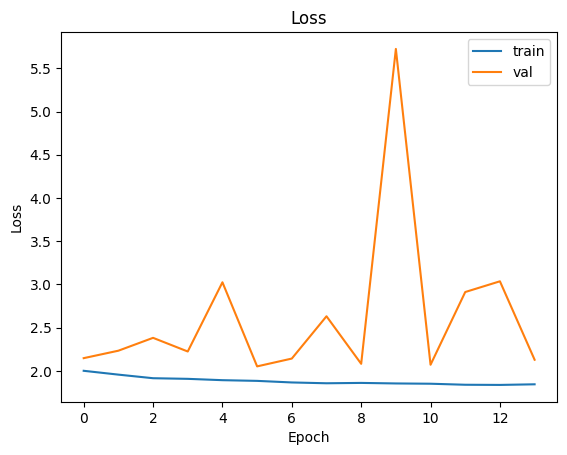

In [14]:
import matplotlib.pyplot as plt

def plot_history(h):
    plt.figure(); plt.plot(h.history['accuracy']); plt.plot(h.history['val_accuracy'])
    plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.legend(['train','val']); plt.show()

    plt.figure(); plt.plot(h.history['loss']); plt.plot(h.history['val_loss'])
    plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(['train','val']); plt.show()

plot_history(history)

In [15]:
import numpy as np
from sklearn.metrics import classification_report

# collect y_true and y_pred from test set
y_true = np.concatenate([y.numpy().argmax(axis=1) for _, y in test_ds])   # one-hot → index
y_prob = model.predict(test_ds, verbose=0)
y_pred = y_prob.argmax(axis=1)

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

       anger     0.0000    0.0000    0.0000       141
    contempt     0.0000    0.0000    0.0000        36
     disgust     0.0000    0.0000    0.0000        54
        fear     0.0000    0.0000    0.0000        92
   happiness     0.2380    1.0000    0.3845       198
  neutrality     0.0000    0.0000    0.0000        84
     sadness     0.0000    0.0000    0.0000       104
    surprise     0.0000    0.0000    0.0000       123

    accuracy                         0.2380       832
   macro avg     0.0297    0.1250    0.0481       832
weighted avg     0.0566    0.2380    0.0915       832



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


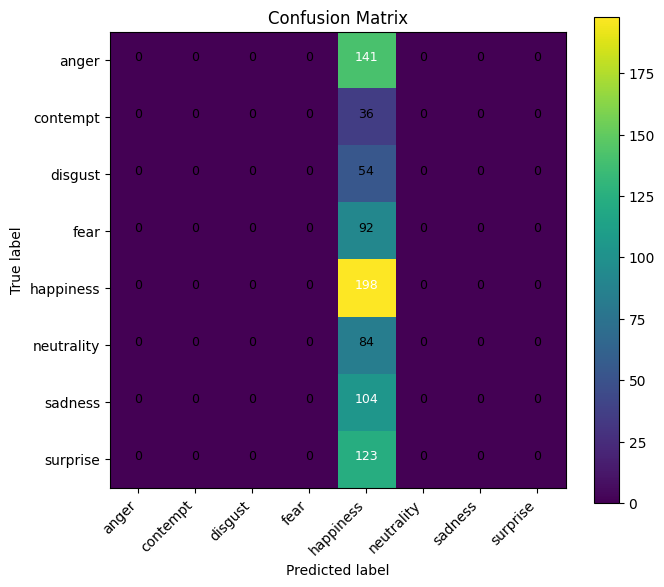

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix"); plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black", fontsize=9)

plt.ylabel('True label'); plt.xlabel('Predicted label')
plt.tight_layout(); plt.show()

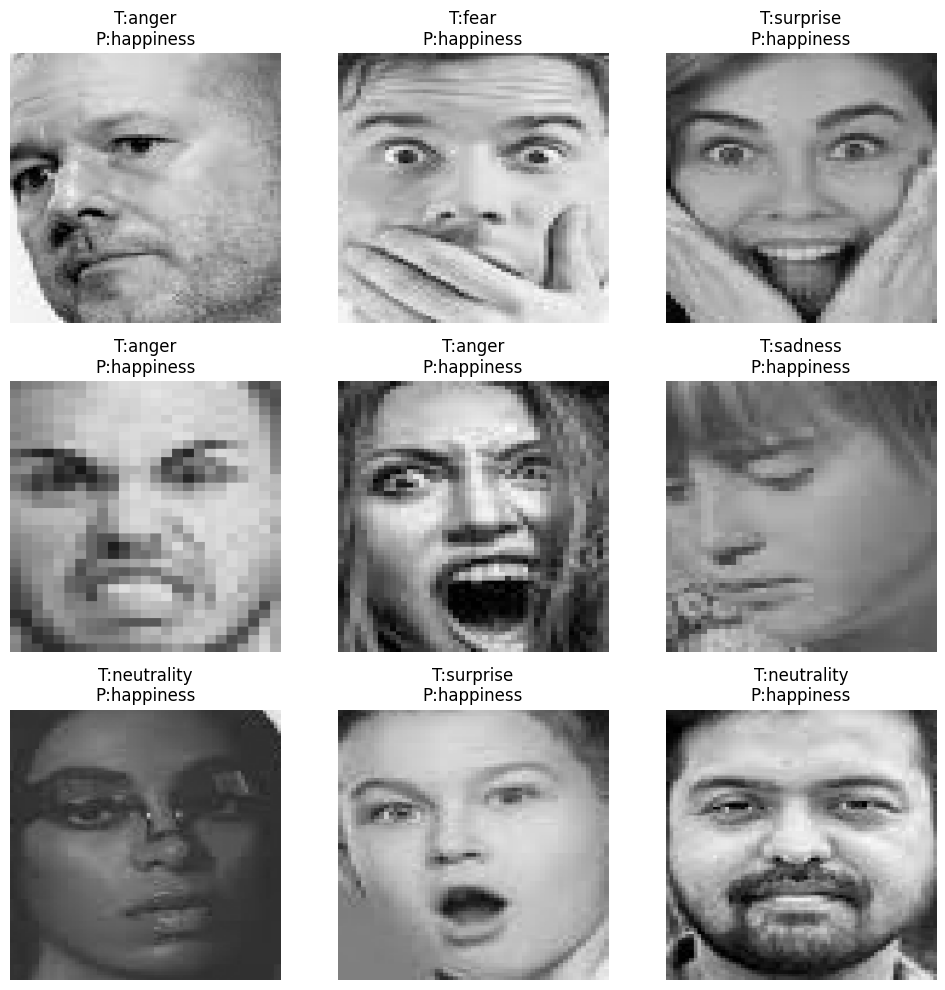

In [17]:
import matplotlib.pyplot as plt

# rebuild arrays of images/labels from a small slice of test_ds
images_list, labels_list = [], []
for x, y in test_ds.take(5):  # 5 batches
    images_list.append(x.numpy())
    labels_list.append(y.numpy())
images = np.concatenate(images_list)
labels = np.concatenate(labels_list)

pred = model.predict(images, verbose=0).argmax(axis=1)
true = labels.argmax(axis=1)

wrong = np.where(pred != true)[0][:9]  # first 9 mistakes
plt.figure(figsize=(10,10))
for i, idx in enumerate(wrong):
    plt.subplot(3,3,i+1)
    plt.imshow(images[idx].astype("float32"))
    plt.title(f"T:{class_names[true[idx]]}\nP:{class_names[pred[idx]]}")
    plt.axis("off")
plt.tight_layout(); plt.show()